---------------------------------------------------------------------------------------------



# **Principles of Autonomy and Decision Making Final Project**

# Task 5: Temporal Planning

### Group 10

*   Qiaohao Liang (hqliang@MIT.EDU)
*   Arkadiusz Balata (arkadius@MIT.EDU)
*   Murielle L.Dunand (mdunand@MIT.EDU)
*   Jinxuan Zhou (janicejz@MIT.EDU)



### **1.0 Background and Introduction**

#### 1.1 Temporal Planning

  Planning problems are a class of problems that require an actor or actions trying to reach a goal. In the most simple case, actions are atomic and deterministic and take place one at a time in a sequence. Actions are often constrained to avoid the sample space from getting too large. When different actions take a variable amount of time and some actions can occur at the same time, we enter into temporal planning. Temporal planning is most used when several actions can be done in parallel and when strict time constriants such as deadlines are involved. This corresponds to setting up a definite temporal plan. 

  To create a temporal plan, actions are encoded on intervals based on when they start and end. The relations between different actions, known as qualitative interval relations, are an essential part of contructing a temporal plan. For example, if actions X is strictly before Y, then X^+ < Y^-, where + encodes the end of an event and - encodes the beginning of it. To complete the temporal plan, we encode these qualitative relations on intervals as relations on time points. This makes a basic graph known as a constraint graph, and is used in simple temporal networks.


#### 1.2 STN Solving

  Temporal relations can be described using an STN (simple temporal network). 
    
  We start off with a constraint graph (as shown in section 2.2.1 below), where the nodes of an STN represent different time points/states, and the edges are labeled by intervals consisting the max and min time this specific action takes. This constraint graph can represent almost all interval relations but cannot show disjoint events, so it is best for closely related times and events. The constrainted graph is mapped over to a distance graph (as shown in section 2.2.2 below). For a distance graph, the upper bounds of intervals are mapped to outgoing arcs, while the lower bounds are mapped to incoming arcs with negatated distances. Note the distance between two of the same nodes are always zero, which is an important feasibility baseline to check when avoiding negative cycles. 
    
  To compute all pairs' shortest paths (APSP), we run the Floyd-Warshall (otherwise Johnson) algorithm on our STN above. The Floyd-Warshall algorithm goes through every path in the graph through two vertices. It incrementally improves the shortest path estimate of each pair by checking if there are any shorter paths available, which takes O(V^3) time where V is the number of vertices. We will then obtain the earliest times and latest times for each action in our decomposed STN graph, also known as ASPS d-graph (as shown in section 2.2.3 below). 

  Pseoducode for Floyd-Warshall:

  Let's say in a distance graph, $d_{ij}$ is (time) distance from vertex i to j.

  1. for $i$ from in 1 to N:
     set $d_{ii}$ = 0

  2. for each of $i, j$ from in 1 to N:
     set $d_{ij}$ = $w_{ij}$ if $w_{ij}$ given in constraints, else $d_{ij}$ = inf
  
  3. for each of $i, j, k$ from in 1 to N:
     set $d_{ij}$ = $min (d_{ij}, d_{ik} + d_{kj})$




    


  These windows of feasible values are then structured into a graph to plan out a schedule using a greedy approach.


  Now we will use an example to illustrate the steps for solving a temporal planning problem.
    


### **2.0 Sample Scenario**： Taxi rides for a romantic date


#### 2.1 Description


Bob is going on a date with his girl friend Suzy. They have a reservation at a restaurant at 7:00pm.

As Bob gets off work, he opens his taxi app. He needs to call 2 taxis, one for himself and one for Suzy.

He puts in his location and Suzy's location, and found out that the closest taxi will take around 3-5 minutes to get to his location, and for Suzy's location it takes 15-20 minutes.

The app also tells him that it will take 40-50 minutes for him to get to the restaurant, depending on the traffic. 
Suzy's office is closer, and it will only take her 20-30 minutes.

The reservation is under Suzy's name so Suzy wants to get there 10-15 mintues before 7:00pm.

Bob wonders when he should put in the request for the two taxis.





#### 2.2 Solution

#####2.2.1 Constraint Graph

As introduced in section 1.2, the first step of solving this problem is translating the word problem into a constraint graph.

In this example, there are 5 events: **Call Taxis**, **Bob Leaves Office**, **Bob Arrives**, **Suzy Leaves Office**, **Suzy Arrives**

In the constraint graph below, each event is represented with a node, and the numbers on the directed edges represent the constraints. 

The code used to construct the graph will be presented in the next section.

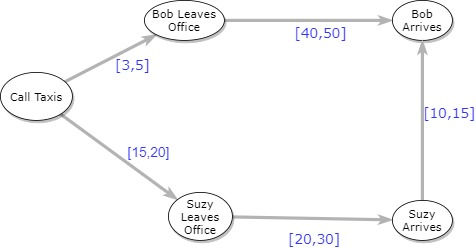

#####2.2.2 Distance Graph

Next, the constrainted graph is mapped over to a distance graph, where the upper bounds of intervals are mapped to outgoing arcs, while the lower bounds are mapped to incoming arcs with negatated distances.

It is also important to check the consistency of the STN at this step.
The distance graph is consistent if and only if there are no negative cycles, and a feasible solution only exists when the distance graph is consistent.

The code used to check the consistency will be presented in the next section.    

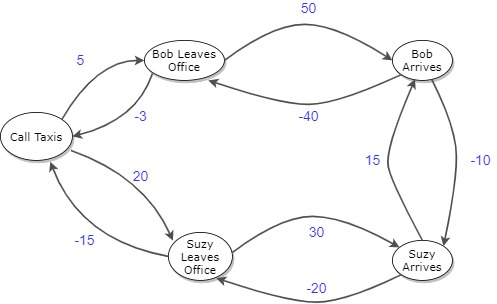

#####2.2.3 APSP Graph

After we have a distance graph, we run the Floyd-Warshall algorithm to compute all pairs' shortest paths (APSP). 

The code used to obtain the APSP will be presented in the next section.    


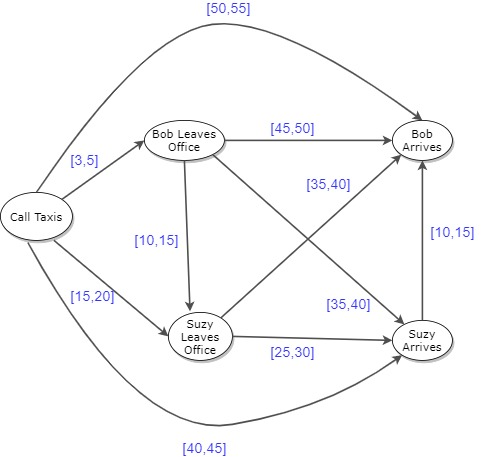

#####2.2.4 Greedy Scheduling

Finally, we can use the information in the APSP to plan out a schedule using a greedy approach.

A feasible shedule is presented in the graph below.

The code used to perform the greedy scheduling will be presented in the next section.



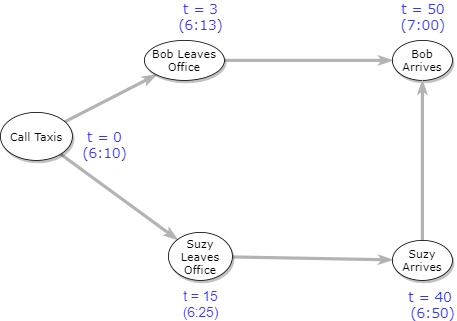

### **3.0 Temporal Planning Code**

#### 3.1 Imports and Class Definitions

Here, we define the node and edges class, as well as a class called "DistancedGraph", which is how we construct our graphs

In [88]:
#IMPORTS
import pydot_ng as pydot
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
import copy as copy
from collections import deque

In [89]:
# basic utils class and functions

class Node(object): 
  # this is our classical node class in search problems
  def __init__(self, action_name, action_time = None):
    self.name = action_name #The name of the action
    self.time = action_time #The time at which the action may take place


  def __repr__(self):
    return "Node(" + self.name + ", " + str(self.time) + ")"

  def __hash__(self):
    return hash((self.name))

  def __eq__(self, other):
    return self.name == other.name

  def get_name(self): #returns the string name of the Node
    return self.name

  def get_time(self): #returns the float starting time of the Node
    return self.time

  def change_time(self, t): #Changes the starting time of the Node to value t
    self.time = t


class Edge(object):
  # this is our classical directional edge class in search problems
    def __init__(self, source, target, weight):
        self.source = source #Node type, the Node that starts the edge
        self.target = target #Node type, the Node that the edge ends at 
        self.weight = weight #float type, the value of the edge

    def __hash__(self):
        return hash("%s_%s_%f" % (self.source, self.target, self.weight))

    def __eq__(self, other):
        return self.source == other.source and self.target == other.target and self.weight == other.weight

    def __repr__(self):
        return "Edge(%r,%r,%r)" % (self.source, self.target, self.weight)


class DistancedGraph(object):
  # this is the distanced graph, which can be constructed from given temporal relations, otherwise known as constraints.
  # graph will store nodes. between each pair of nodes, there will two directional edges, one for upper bound, other for lower bound. 
  # Note direction here is used to determine + or - value for edge.
  # 
    def __init__(self):
        self._nodes = [] #A list of Nodes, [Node1, Node2, Node3...]
        self._edges = dict() #A dictionary of lists of Edges, keys are Nodes. {Node("A"): {Edge1, Edge2}, Node("B"): {Edge2}....}
        self.node_positions = dict() #used for drawing out the graph, not needed for computation.
        self.edge_array = None #an alternate view of the nodes and edges as a NP array.

        """
        Example:
            X1  X2  X3  X4  X5
        X1  0          -20
        X2      0
        X3          0
        X4 30           0
        X5                  0

        In this array, the edge X1--->X4 has weight -20, the edge X4--->X1 has weight 30.
        """
        

    def __contains__(self, node):
      return node in self._nodes

    def add_node(self, node): #Adds a new Node object to the DistancedGraph
      if node not in self._nodes:
        self._nodes.append(node)
        if self.edge_array is None:
          self.edge_array = np.array([[np.Inf]])

        else:
          self.edge_array = np.hstack((self.edge_array, np.ones((self.edge_array.shape[0], 1))*np.Inf))
          self.edge_array = np.vstack((self.edge_array, np.ones((1, self.edge_array.shape[1]))*np.Inf))

    def change_time(self, node, t): #Changes the time attribute of a given Node

      self._nodes[self._nodes.index(node)].change_time(t)

      name = node.get_name()
      for k in self._edges.keys():
        for edge in self._edges[k]:
          if edge.source.get_name() == node.get_name():
            edge.source.change_time(t)
          if edge.target.get_name() == node.get_name():
            edge.target.change_time(t)



    def add_edge(self, node1, node2, constraint): #Adds a new edge of the graph
      #Inputs: Node, Node, tuple of (lower bound, upper bound)


        #Node1 ---> Node2
        self.add_node(node1)
        self.add_node(node2)
        ind1 = self._nodes.index(node1)
        ind2 = self._nodes.index(node2)
        
        node1_edges = self._edges.get(node1, set())
        node1_edges.add(Edge(node1, node2, constraint[1]))
        self._edges[node1] = node1_edges

        self.edge_array[ind1, ind2] = constraint[1]

        #Node2 ---> Node1
        node2_edges = self._edges.get(node2, set())
        node2_edges.add(Edge(node2, node1, -1*constraint[0]))
        self._edges[node2] = node2_edges

        self.edge_array[ind2, ind1] = -1*constraint[0]

    def edge_value(self, node1, node2): #Returns the weight of the edge between Node1 and Node2
      ind1 = self._nodes.index(node1)
      ind2 = self._nodes.index(node2)
      return self.edge_array[ind1, ind2]

    def update_edge(self, node1, node2, value): #Changes the weight of given edge between Node1 and Node2 to be value
      exists = False
  
      set_of_edges = self._edges[node1]
      for e in set_of_edges:
        if e.target == node2:
          e.weight = value
          exists = True

      if not exists:
        self.add_node(node1)
        self.add_node(node2)

        node1_edges = self._edges.get(node1, set())
        node1_edges.add(Edge(node1, node2, value))
        self._edges[node1] = node1_edges

      ind1 = self._nodes.index(node1)
      ind2 = self._nodes.index(node2)
      self.edge_array[ind1, ind2]=value


    def set_node_positions(self, positions): #For drawing out the graph, not used
        self.node_positions = positions


    def set_node_pos(self, node, pos): #For drawing out the graph, not used
        """Sets the (x,y) pos of the node, if it exists in the graph."""
        if not node in self:
            raise NodeNotInGraph(node)
        self.node_positions[node] = pos

    def get_node_pos(self, node): #For drawing out the graph, not used
        if not node in self:
            raise NodeNotInGraph(node)
        return self.node_positions[node]

    def node_edges(self, node): #For drawing out the graph, not used
        if not node in self:
            raise NodeNotInGraph(node)
        return self._edges.get(node, set())

    def draw(self, highlight_edges=None): #For drawing out the graph, not used
        nxg = nx.DiGraph(directed=True)
        edges = [(e.source, e.target, {'weight':e.weight, 'inv_weight':1.0/e.weight}) for node_set in self._edges.values() for e in node_set]
        nxg.add_edges_from(edges)
        if len(self.node_positions) < len(self._nodes):
            # Calculate positions for nodes whose pos is not specified.
            pos = nx.spring_layout(nxg, weight='inv_weight', pos=self.node_positions, fixed=self.node_positions.keys() if self.node_positions else None)
        else:
            pos = self.node_positions


        f = plt.figure(figsize=(8,8))
        plt.gca().set_aspect('equal', adjustable='box')
        nx.draw_networkx_nodes(nxg, pos, node_color='w')
        nx.draw_networkx_edges(nxg, pos, edges, connectionstyle='arc3,rad=0.1')
        nx.draw_networkx_labels(nxg, pos)
        edge_labels=dict([((u,v,),"%s" % d['weight'])
                 for u,v,d in nxg.edges(data=True)])
        nx.draw_networkx_edge_labels(nxg, pos, edge_labels=edge_labels, label_pos=0.15, font_size=10)


        if highlight_edges:
            nx.draw_networkx_edges(nxg, pos, highlight_edges, edge_color='r')
        
        plt.axis('off')
        plt.show()




#### 3.2  Making the Initial Distance Graph

With the DistancedGraph object, we can plug in the time intervals of the word problem and output an initial distance graph. As we stated before, the upper bound of the interval is the forward edge, while the lower bound is negated and made into the backward edge. 

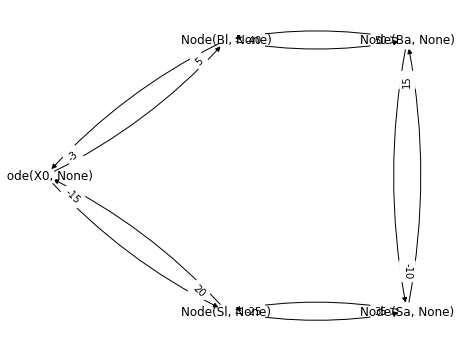

In [90]:
bob_constraintGraph = DistancedGraph()

bob_constraintGraph.add_edge(Node("X0"), Node("Bl"), (3, 5))
bob_constraintGraph.add_edge(Node("X0"), Node("Sl"), (15, 20))
bob_constraintGraph.add_edge(Node("Bl"), Node("Ba"), (40, 50))
bob_constraintGraph.add_edge(Node("Sl"), Node("Sa"), (25, 35))
bob_constraintGraph.add_edge(Node("Sa"), Node("Ba"), (10, 15))

# print(bob_constraintGraph2._nodes)
# print(bob_constraintGraph2._edges)
# print(bob_constraintGraph2.edge_array)
example_node_locations = {Node("X0"): (0,2.5), Node("Bl"): (2,4), Node("Sl"): (2,1), Node("Sa"): (4, 1), Node("Ba"): (4, 4)}
bob_constraintGraph.set_node_positions(example_node_locations)

bob_constraintGraph.draw()

Clean it up and we get this.

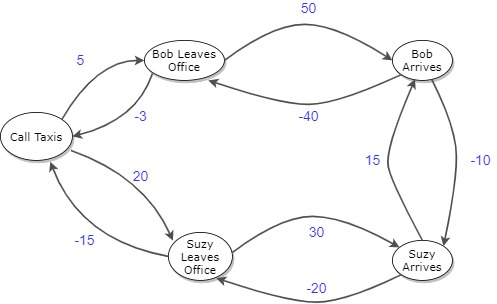

#### 3.3 Checking for consistency
Sometimes, a temporal problem may have no solution. This could be when the problem is badly worded, or when one event feeds into itself. Either way, there is no feasible solution and we can stop trying to find one early. This is more efficient, and where the first part of our DistanceGraph object comes in useful. Because we negated the lower bounds of the intervals, if there is any negative cycle in the graph, the STN is inconsistent. A negative cycle means that any greedy search that runs through this graph will get stuck forever, constantly decreasing the cost of the path. This is not realistic and is not a feasible solution to the temporal problem.

In [91]:
def check_consistency(distanced_graph, threshold):
  # checks the consistency of the STN and feasibility of solutions
  # looks through all possible cycles (start & end at same node)
  # if finds cycle with total cost < 0, STN is inconsistent


  # initialize action_time = inf for all nodes in graph G
  # initialize action_time = 0 for starting node
  # termination: any action_time value goes below threshold
  # while check_queue != []
  # update node action_time and add nodes whose action_time are updated to the check_queue
  
  distanced_graph_copy = DistancedGraph()
  distanced_graph_copy._nodes = copy.deepcopy(distanced_graph._nodes) 
  distanced_graph_copy._edges = copy.deepcopy(distanced_graph._edges)  
  
  distanced_graph_copy.edge_array = copy.deepcopy(distanced_graph.edge_array)  
  
  consistency = True
 
  # initialize action_time = inf for all nodes in graph G
  for node in distanced_graph_copy._nodes:
    distanced_graph_copy.change_time(node, math.inf)
  
  # initialize action_time = 0 for starting node
  distanced_graph_copy.change_time(distanced_graph_copy._nodes[0], 0)

  # initialize check_queue
  check_queue = []
  new_action_time = 0
  
  for node in distanced_graph_copy._nodes:
    check_queue.append (node)

  while check_queue != [] and consistency == True:
    check_node = check_queue.pop (0)
    

    for edge in distanced_graph_copy._edges[check_node]:
      
      new_action_time = check_node.time + edge.weight


      if new_action_time < edge.target.time:

        distanced_graph_copy.change_time(edge.target, new_action_time)
        
        check_queue.append (edge.target)
      
      if new_action_time < threshold:
        consistency = False
        break
    
  return consistency

In [92]:
consistency = check_consistency(bob_constraintGraph,-100)
print ("The STN is consistent: ", consistency)

The STN is consistent:  True


#### 3.4 Decomposition
Now that we have checked that the STN is consistent, we can start to solve it. The first step is to turn the distance graph into a decomponsed STN. We use the Floyd-Warshall algorithm to find the true shortest paths between nodes. For every pair of nodes, we check for the path of minimum length, and set that minimum path to be the new best edge between the pair. 

In [ ]:
def decomposition(distanced_graph):
  # turns distanced graph into decomposed STN via Floyd-Warshall algorithm
  # See lecture slides pg 60-83 for implementation

  # lets first make a copy of input distanced_graph so that we don't change it
  # distanced_graph should already have all nodes and edges (from constraints) stored
  # ASPS is our final return object

  APSP = DistancedGraph()
  APSP._nodes = copy.deepcopy(distanced_graph._nodes) 
  APSP._edges =  copy.deepcopy(distanced_graph._edges)  
  APSP.node_positions = copy.deepcopy(distanced_graph.node_positions)   
  APSP.edge_array = copy.deepcopy(distanced_graph.edge_array)   
  
  n = len(APSP._nodes)

  # add distance from node a to node a = 0

  for i in np.arange(n):
    node_i = APSP._nodes[i]
    APSP.add_edge(node_i, node_i, (0,0))

  # Floyd Warshall

  for k in np.arange(n):
    node_k = APSP._nodes[k]
    for i in np.arange(n):
      node_i = APSP._nodes[i]
      for j in np.arange(n):
        node_j = APSP._nodes[j]

        APSP.update_edge(node_i, node_j, min(APSP.edge_value(node_i, node_j), 
                                             APSP.edge_value(node_i, node_k) + APSP.edge_value(node_k, node_j)
                                             ))
  # print(APSP.edge_array)
  return APSP
  # which is still a distanced_graph object, just its edge values changed from the input distanced_graph 
  # also known as APSP, d-graph






In [ ]:
APSP = decomposition(bob_constraintGraph)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:169: RuntimeWarning: divide by zero encountered in double_scalars


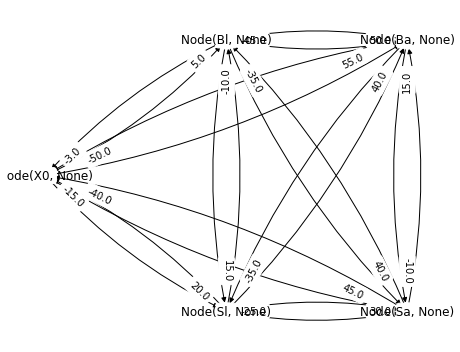

In [ ]:
APSP.draw()

Clean it up and we get this.

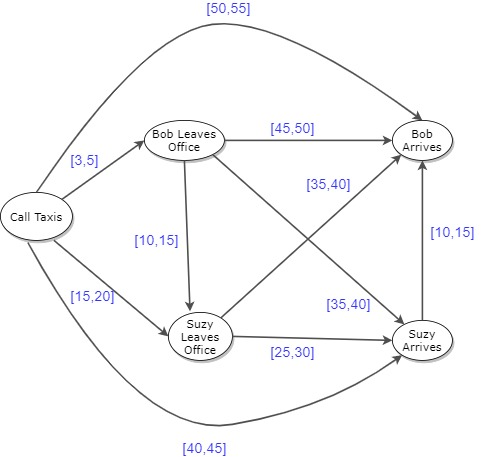

#### 3.5 Greedy Solution
Since we've optimized the distance graph using the Floyd-Warshall algorithm and set the edges to be the true shortest paths between nodes, we can just use greedy scheduling to find the solution to our STN. This means starting at the earliest node in the problem and always picking the path with the shortest path until a solution has been found.

In [ ]:
def greedy_schedule(decomposed_STN, heuristic = min):
  """
  Assigns time value for each node in graph based on heuristic.
  decomposed_STN: APSP graph
  heuristic: function max or function min
  """
  n = len(decomposed_STN._nodes)
  feasible_sols = dict(zip(map(lambda x: x.get_name(), decomposed_STN._nodes), [[float('-inf'), float('inf')] for i in range(n)]))

  queue = deque()

  for node in decomposed_STN._nodes:
    dependent = False
    for edge in decomposed_STN.node_edges(node):
      if edge.weight < 0:
        dependent = True
    if not dependent:
      feasible_sols[node.get_name()] = [0, 0]
      decomposed_STN.change_time(node, 0)
      queue.append(node)
      break

  visited = set()
  while queue:
    node = queue.popleft()
    visited.add(node.get_name())

    if node.get_time() is None:
      new_val = heuristic(feasible_sols[node.get_name()])
      decomposed_STN.change_time(node, new_val)
      feasible_sols[node.get_name()] = [new_val, new_val]

    for edge in decomposed_STN.node_edges(node):
      neighbor = edge.target
      weight = decomposed_STN.edge_value(edge.source, edge.target)
      opposite = -decomposed_STN.edge_value(edge.target, edge.source)
      feasible_sols[neighbor.get_name()] = [min(feasible_sols[neighbor.get_name()][1], max(node.get_time() + opposite, feasible_sols[neighbor.get_name()][0])),
                                            max(feasible_sols[neighbor.get_name()][0], min(node.get_time() + weight, feasible_sols[neighbor.get_name()][1]))]

      if neighbor.get_name() not in visited:
        queue.append(neighbor)

  assignments = {}
  print("Assignments (raw):")
  for node in decomposed_STN._nodes:
    print(f'{node.get_name()}: t = {node.get_time()}')
    assignments[node.get_name()] = node.get_time()

  return assignments



In [ ]:
APSP = decomposition(bob_constraintGraph)
assignments = greedy_schedule(APSP, min)
difference = 420 - max(assignments.values())
print('Assignments (actual times)')
for node in assignments:
  assignments[node] += difference
  print(f'{node}: at {int(assignments[node]//60)}:{int(assignments[node]-60*(assignments[node]//60)):02d}')



Assignments (raw):
X0: t = 0
Bl: t = 3.0
Sl: t = 15.0
Ba: t = 50.0
Sa: t = 40.0
Assignments (actual times)
X0: at 6:10
Bl: at 6:13
Sl: at 6:25
Ba: at 7:00
Sa: at 6:50


In [ ]:
# if you'd like to use max as heuristic, uncomment and run the following code

# # generating new but same APSP graph since calling greedy_schedule in the cell above already assigned time values for each node based on min heuristic 
# APSP = decomposition(bob_constraintGraph)
# assignments = greedy_schedule(APSP, max)
# difference = 420 - max(assignments.values())
# print('Greedy Assignments (actual times)')
# for node in assignments:
#   assignments[node] += difference
#   print(f'{node}: at {int(assignments[node]//60)}:{int(assignments[node]-60*(assignments[node]//60)):02d}')

In [ ]:
def check_assignment(graph):
  for node in graph._nodes:
    for edge in graph.node_edges(node):
      neighbor = edge.target
      weight = graph.edge_value(edge.source, edge.target)
      opposite = -graph.edge_value(edge.target, edge.source)

      if not (opposite <= neighbor.get_time() - node.get_time() <= weight):
        print(f'{node} has an invalid assignment')
        return

  return "Valid Assignment"

In [ ]:
print(check_assignment(APSP))

Valid Assignment


### **4.0 Results & Discussion**




#### 4.1 Final Results

As we can see, our steps outputted the correct answer. If we go through the time, we see that everyone gets to the destination on time, and we get a sample solution for when Bob should call a taxi: X0: at 6:10, Bl: at 6:13, Sl: at 6:25, Ba: at 7:00, Sa: at 6:50. This method was optimal for the problem, which is defined as calling the taxies as early as possible.


#### 4.2 What Happens if the STN is not Consistent?


As mentioned earlier, before we move on to finding the solution, it is very important to check if the given STN is consistent. If not, we will not be able to find a feasible solution.

In the example above, we have checked and shown that the STN generated from the problem is consistent.

Now, think about the following scenario: The traffic is really bad during rush hours and it will actually take Bob 70-80 minutes to get to the restaurant. 

Is there is a feasible plan for Bob to call the two taxis at the same time?

The graph below shows the new scenario and the code is telling us that the STN is inconsistent, meaning there is a negative cycle and no solution can be found.



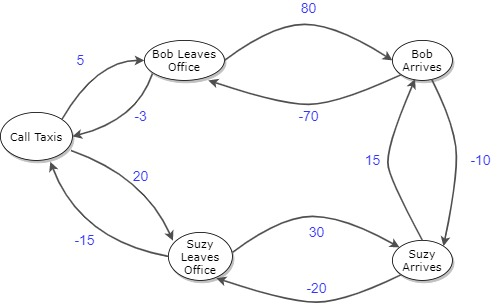

In [99]:
bob_constraintGraph2 = DistancedGraph()

bob_constraintGraph2.add_edge(Node("X0"), Node("Bl"), (3, 5))
bob_constraintGraph2.add_edge(Node("X0"), Node("Sl"), (15, 20))
bob_constraintGraph2.add_edge(Node("Bl"), Node("Ba"), (70, 80))
bob_constraintGraph2.add_edge(Node("Sl"), Node("Sa"), (25, 35))
bob_constraintGraph2.add_edge(Node("Sa"), Node("Ba"), (10, 15))

# print(bob_constraintGraph2._nodes)
# print(bob_constraintGraph2._edges)
# print(bob_constraintGraph2.edge_array)
example_node_locations = {Node("X0"): (0,2.5), Node("Bl"): (2,4), Node("Sl"): (2,1), Node("Sa"): (4, 1), Node("Ba"): (4, 4)}
bob_constraintGraph2.set_node_positions(example_node_locations)

#bob_constraintGraph2.draw()

In [100]:
consistency = check_consistency(bob_constraintGraph2,-100)
print ("The STN is consistent: ", consistency)
print ("No feasible solution.")

The STN is consistent:  False
No feasible solution.


#### 4.3 Why Can't We Do Greedy Scheduling Directly?


After seeing all the code, one might ask: why couldn't we just schedule greedily directly from the beginning?

Here we present a case where greedy schedule will fail.

For example, we assign t = 0 for event X0 as the start node, and assign the max numbers each time range for Bl, Sl and Sa.



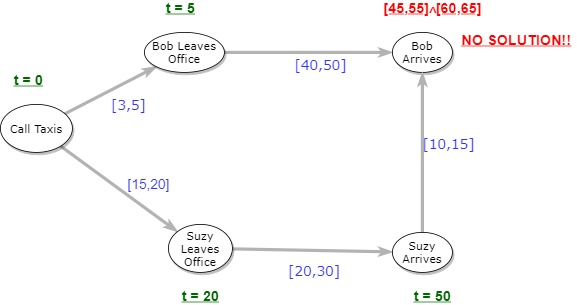

Now we run into a problem: there is no feasible assignment left for Ba! :(

This is telling us that we should always run the greedy approach on the APSP graph.

#### 4.4 Run Time Analyses




The most time consuming step is decomposition O(V^3), and greedy scheduling O(V^2), which could be problematic as the running time does not scale well with increasing number of events (vertices). However, do realize that this scheduling problem is relatively complex, and could 100% result in either inconsistent problem warning or solved schedule, so given the right application scenario, the O(V^3) time complexity can be tolerated. 



#### 4.5 Final Notes


Note as a practitioner of autonomy and decision making methods, there should be important questions asked before decision the applicability of temporal planning in a problem. Not only does it have to be a scheduling problem where actions take place in the same time, but also all constraints can be written in the form: event 1 takes before event 2, the given constraints should be indicating the min and max time difference between the event 1 and event 2.

Of course, the solution we get depends on the heuristic we are using. Here, we use the earliest time possible, and our solution also works with a latest time possible heuristic. However, we do not have any more complicated heuristics set up, so for a different type of problem they would have to be added. Overall though, using a APSP graph is useful for most types of temporal problems. We hope that this will be a useful resource on completing temporal problems going forwards.